**簡単な説明**

先にMLbot_1のコードを読んだ方が理解しやすい．  
概要としては，MLbot_1においてlightGBMを用いてリターン(y_buyとy_sell)を予測していたのを，LSTM+FCNNというニューラルネットワーク構造で予測するという内容．

- In[1] ライブラリのimport
- In[2] dataset(pytorchのdataloaderを使うために必要なもの)とモデル(ネットワークの構成を決めるもの)のclassを定義
- In[3] tableデータにMLbot_1と同様の処理(前処理無しだと全く学習しなかったので雑な前処理だけは入れた)を行ってリターンの列を追加．さらにLSTMに入力可能なデータ形式に加工．
- In[4] 1エポック分の学習部分と検証部分を関数化
- In[5] buy方向モデルの学習パート．In[2]で作ったclassを用いてモデルとモデルに入力するデータを作り，指定したエポックだけ学習と検証を行う(In[4]の関数を使う)．損失(予測したリターンと正しいリターンの平均二乗誤差)と精度(リターンについてTrue Positiveの割合%)の学習過程をグラフに図示する．
- In[6] sell方向モデルの学習パート．In[5]と同様．
- In[7] 学習済みのモデルを用いて，全データ(訓練データ+検証データ+テストデータ)に対するリターンの予測値を求める．リターンyの予測値が0より大きい場合に注文を入れたとして，全データに対する累積リターンを図示する

**改良の余地がある部分**

MLbot_1と共通の部分
- 特徴量の前処理
- 特徴量を増やす(そもそも取得するデータを増やす or 今あるデータを加工してかさ増しする)
- 執行方法を工夫する(今回は手数料が高い成行決済を用いている + 同じ方向の注文が連続しても毎回決済しているので手数料が多い)
- ハイパーパラメータ(ネットワークの入出力データの次元，ネットワークの層数，その他参考になる値がないパラメータ等)を最適化する
-  hold-out以外のバリデーションを用いる
- 問題設定の変更(リターンyの回帰予測ではなく，リターンyが正か負のどちらを取るかの二値分類とするとか)
- 注文条件の変更(リターンyが0より大きい場合に注文ではなく，100より大きい場合に注文とすることで負けにくくするとか)

NNbot_1独自の部分
- ネットワークの構成を変える
- 重みの初期化の実装
- 正則化の実装
- DropOutの実装
- EarlyStoppingの実装

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# classの定義

# dataset class
class MyDataset(Dataset):
    def __init__(self, features, y):
        super(MyDataset, self).__init__()
        self.features = features
        self.y = y
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.y[idx])

# model
class LSTM_Linear(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(LSTM_Linear, self).__init__()
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=inputDim, hidden_size=hiddenDim, num_layers=2, batch_first=True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs):
        output, (hidden, cell) = self.lstm(inputs)
        output = self.output_layer(output[:,-1,:])
        return output

In [3]:
# 特徴量エンジニアリング

# 欠損値を指定してdata.csvを読み込む
df = pd.read_csv('../Record/60/data.csv', index_col=0, na_values='#####')
df = df.astype('float32')

# 欠損値を前後の値から線形補完
df.interpolate(limit_direction='both', inplace=True)

# リターンyをdataframeに追加
# df['fee'] = (df['closeprice'] + (df['closeprice'] - df['closeprice'].diff(-1)))*0.00036←手数料を考慮する場合
df['fee'] = (df['closeprice'] + (df['closeprice'] - df['closeprice'].diff(-1)))*0
df['y_buy'] = (-1) * df['closeprice'].diff(-1) - df['fee']
df['y_sell'] = df['closeprice'].diff(-1) - df['fee']

# 一番下の列はリターンyが定義できないので消去
df.dropna(inplace = True)

# 特徴量として使う列を標準化(平均0，分散と標準変化が1になるようにする)←雑な前処理なので変えた方が良い
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)
features_col = df.columns.values[1:-3]
df[features_col] = mean_norm(df[features_col])

# 時系列データの[x1,x2,x3,...,x_10],[x2,x3,x4,...,x11],[x3,x4,x5,...,x12],...を作る
sequence = 10
features = np.array([df[i:i+sequence][features_col] for i in range((len(df)+1)-sequence)])
y_buy = np.array([df[i:i+sequence]['y_buy'] for i in range((len(df)+1)-sequence)])
y_buy = y_buy.reshape(y_buy.shape[0],y_buy.shape[1],-1)
y_sell = np.array([df[i:i+sequence]['y_sell'] for i in range((len(df)+1)-sequence)])
y_sell = y_sell.reshape(y_sell.shape[0],y_sell.shape[1],-1)

In [4]:
# 学習と検証部分を関数化

def train(model):
    model.train()

    running_loss = 0
    training_accuracy = 0
    count = 0.001

    for inputs, y in trainloader:
        optimizer.zero_grad()
        pred_y = model(inputs)
        loss = criterion(pred_y, y[:, -1, :])
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            running_loss += loss.item()
            # training_accuracy：「リターンyの予測が正でかつ実際の予測が正」である場合の数，count：「リターンyの予測が正」である場合の数
            training_accuracy += torch.sum((pred_y > 0) & (y[:, -1, :] > 0)).item()
            count += torch.sum((pred_y > 0)).item()
    
    # 学習データに対する損失とTrue Positiveの割合%を返す
    return running_loss / len(trainloader), training_accuracy / count * 100


def valid(model):
    model.eval()

    running_loss = 0
    valid_accuracy = 0
    count = 0.001

    for inputs, y in validloader:
        pred_y = model(inputs)
        loss = criterion(pred_y, y[:, -1, :])

        with torch.no_grad():
            running_loss += loss.item()
            # valid_accuracy：「リターンyの予測が正でかつ実際の予測が正」である場合の数，count：「リターンyの予測が正」である場合の数
            valid_accuracy += torch.sum((pred_y > 0) & (y[:, -1, :] > 0)).item()
            count += torch.sum((pred_y > 0)).item()
    
    # 検証データに対する損失とTrue Positiveの割合%を返す
    return running_loss / len(validloader), valid_accuracy / count * 100

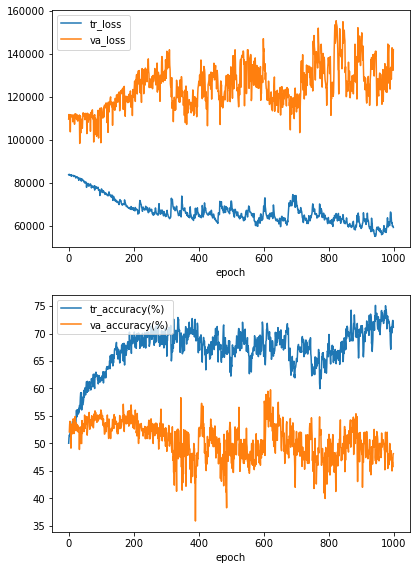

In [5]:
# buy方向モデルの学習

tr_loss_buy = []
tr_acc_buy = []
va_loss_buy = []
va_acc_buy = []

# 特徴量とラベルを[8:1:1]=[学習データ(tr):検証データ(va):テストデータ(te)]の割合で分割
tr_features, va_features, tr_y_buy, va_y_buy = train_test_split(features, y_buy, test_size=0.2, random_state=1, shuffle=False)
va_features, te_features, va_y_buy, te_y_buy = train_test_split(va_features, va_y_buy, test_size=0.5, random_state=1, shuffle=False)

# パラメータ
batchsize = 20
lr = 0.01
epochs = 1000

# 学習データをミニバッチに分割してイテレーターにする
dataset = MyDataset(tr_features, tr_y_buy)
trainloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)
# 訓練データをミニバッチに分割してイテレーターにする
dataset = MyDataset(va_features, va_y_buy)
validloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)

# モデル，最適化関数，評価関数を呼び出す
model_buy = LSTM_Linear(inputDim=len(features_col), hiddenDim=5, outputDim=1)
optimizer = optim.Adam(model_buy.parameters(),lr=lr)
criterion = nn.MSELoss()

# 指定したエポック数だけ学習させる．また，学習過程における学習データと検証データの損失とTrue Positiveの割合を表示する．
for epoch in range(1, epochs+1):
    loss, acc = train(model_buy)
    # print('--------------------------------------------------')
    # print('Epoch is', epoch)
    # print('training_loss is', loss)
    # print('training_accuracy(%) is', acc)
    tr_loss_buy.append(loss)
    tr_acc_buy.append(acc)

    loss, acc = valid(model_buy)
    # print('valid_loss is', loss)
    # print('valid_accuracy(%) is', acc)
    va_loss_buy.append(loss)
    va_acc_buy.append(acc)

# 学習過程における学習データと検証データの損失とTrue Positiveの割合を図示する．
fig = plt.figure(figsize=(6.4, 4.8*2))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

x = [i for i in range(epochs)] 
tr_acc_buy = [None if i == 0 else i for i in tr_acc_buy]
va_acc_buy = [None if i == 0 else i for i in va_acc_buy]

ax1.plot(x, tr_loss_buy, label='tr_loss')
ax1.plot(x, va_loss_buy, label='va_loss')
ax2.plot(x, tr_acc_buy, label='tr_accuracy(%)')
ax2.plot(x, va_acc_buy, label='va_accuracy(%)')

ax1.set_xlabel('epoch')
ax2.set_xlabel('epoch')

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')

plt.show()

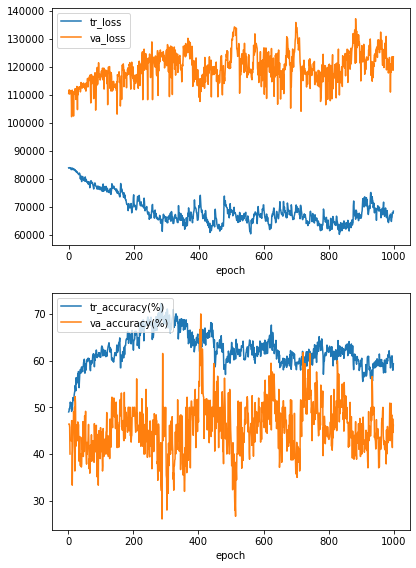

In [6]:
# sell方向モデルの学習

tr_loss_sell = []
tr_acc_sell = []
va_loss_sell = []
va_acc_sell = []

# 特徴量とラベルを[8:1:1]=[学習データ(tr):検証データ(va):テストデータ(te)]の割合で分割
tr_features, va_features, tr_y_sell, va_y_sell = train_test_split(features, y_sell, test_size=0.2, random_state=1, shuffle=False)
va_features, te_features, va_y_sell, te_y_sell = train_test_split(va_features, va_y_sell, test_size=0.5, random_state=1, shuffle=False)

# パラメータ
batchsize = 20
lr = 0.01
epochs = 1000

# 学習データをミニバッチに分割してイテレーターにする
dataset = MyDataset(tr_features, tr_y_sell)
trainloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)
# 検証データをミニバッチに分割してイテレーターにする
dataset = MyDataset(va_features, va_y_sell)
validloader = DataLoader(dataset, batch_size = batchsize, shuffle=True, drop_last = True)

# モデル，最適化関数，評価関数を呼び出す
model_sell = LSTM_Linear(inputDim=len(features_col), hiddenDim=5, outputDim=1)
optimizer = optim.Adam(model_sell.parameters(),lr=lr)
criterion = nn.MSELoss()

# 指定したエポック数だけ学習させる．また，学習過程における学習データと検証データの損失とTrue Positiveの割合を表示する．
for epoch in range(1, epochs+1):
    loss, acc = train(model_sell)
    # print('--------------------------------------------------')
    # print('Epoch is', epoch)
    # print('training_loss is', loss)
    # print('training_accuracy(%) is', acc)
    tr_loss_sell.append(loss)
    tr_acc_sell.append(acc)

    loss, acc = valid(model_sell)
    # print('valid_loss is', loss)
    # print('valid_accuracy(%) is', acc)
    va_loss_sell.append(loss)
    va_acc_sell.append(acc)

# 学習過程における学習データと検証データの損失とTrue Positiveの割合を図示する．
fig = plt.figure(figsize=(6.4, 4.8*2))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

x = [i for i in range(epochs)] 
tr_acc_sell = [None if i == 0 else i for i in tr_acc_sell]
va_acc_sell = [None if i == 0 else i for i in va_acc_sell]

ax1.plot(x, tr_loss_sell, label='tr_loss')
ax1.plot(x, va_loss_sell, label='va_loss')
ax2.plot(x, tr_acc_sell, label='tr_accuracy(%)')
ax2.plot(x, va_acc_sell, label='va_accuracy(%)')

ax1.set_xlabel('epoch')
ax2.set_xlabel('epoch')

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')

plt.show()

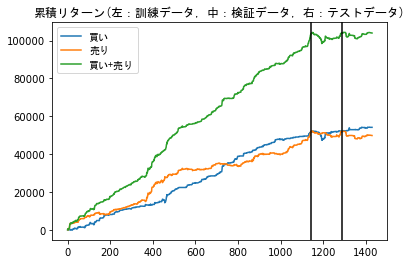

In [7]:
# 学習したモデルで実際に予測を行う

# モデルの入力にはバッチの次元が必要なのでその分を増やす
features = torch.tensor(np.expand_dims(features, 0))
y_buy = torch.tensor(np.expand_dims(y_buy, 0))
y_sell = torch.tensor(np.expand_dims(y_sell, 0))

# buy方向モデル
model_buy.eval()
pred_y_buy_list = []
y_buy_list = []

# 全データ(訓練データ+検証データ+テストデータ)を学習済みのモデルに入力する
for i in range(len(features[0])):
    pred_y_buy = model_buy(features[:,i,:,:])
    
    pred_y_buy_list.append(pred_y_buy[0,0].item())
    y_buy_list.append(y_buy[0,i,-1,0].item())

# 出力をpd.Seriesに変換する
pred_y_buy = pd.Series(data = pred_y_buy_list, name= 'pred_y_buy')
y_buy = pd.Series(data = y_buy_list, name= 'y_buy')

# sell方向モデル
model_sell.eval()
pred_y_sell_list = []
y_sell_list = []

# 全データ(訓練データ+検証データ+テストデータ)を学習済みのモデルに入力する
for i in range(len(features[0])):
    pred_y_sell = model_sell(features[:,i,:,:])
    pred_y_sell_list.append(pred_y_sell[0,0].item())
    y_sell_list.append(y_sell[0,i,-1,0].item())

# 出力をpd.Seriesに変換する
pred_y_sell = pd.Series(data = pred_y_sell_list, name= 'pred_y_sell')
y_sell = pd.Series(data = y_sell_list, name= 'y_sell')

# 予測が正の場合に注文したとして累計リターンを図示する
df_result = pd.concat([y_buy, pred_y_buy, y_sell, pred_y_sell], axis=1)
(df_result['y_buy'] * (df_result['pred_y_buy'] > 0)).cumsum().plot(label='買い')
(df_result['y_sell'] * (df_result['pred_y_sell'] > 0)).cumsum().plot(label='売り')
(df_result['y_buy'] * (df_result['pred_y_buy'] > 0) + df_result['y_sell'] * (df_result['pred_y_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.legend(prop={"family":"MS Gothic"})
plt.title('累積リターン(左：訓練データ，中：検証データ，右：テストデータ)', fontname="MS Gothic")
plt.axvline(x=len(features[0])*(8/10), color='k')
plt.axvline(x=len(features[0])*(9/10), color='k')
plt.show()

In [8]:
# 全データを使って本番用モデルを作る

# モデルの保存
# torch.save(model_buy.state_dict(), 'buy_model.pth')

# モデルの保存
# torch.save(model_sell.state_dict(), 'sell_model.pth')